In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio
import cv2

In [2]:
# Load CIFAR-10 dataset
(X_train, _), (X_test, _) = keras.datasets.cifar10.load_data()
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)

170498071/170498071 [==============================] - 5s 0us/step
X_train shape is  (50000, 32, 32, 3)
X_test shape is  (10000, 32, 32, 3)


In [3]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [4]:
X_train_gray = np.dot(X_train[..., :3], [0.2989, 0.5870, 0.1140])
X_test_gray = np.dot(X_test[..., :3], [0.2989, 0.5870, 0.1140])
print('X_train_gray shape is ' , X_train_gray.shape)
print('X_test_gray shape is ' , X_test_gray.shape)

X_train_gray shape is  (50000, 32, 32)
X_test_gray shape is  (10000, 32, 32)


In [5]:
X_train_gray = np.expand_dims(X_train_gray, axis=-1)
X_test_gray = np.expand_dims(X_test_gray, axis=-1)
print('X_train_gray shape is ' , X_train_gray.shape)
print('X_test_gray shape is ' , X_test_gray.shape)

X_train_gray shape is  (50000, 32, 32, 1)
X_test_gray shape is  (10000, 32, 32, 1)


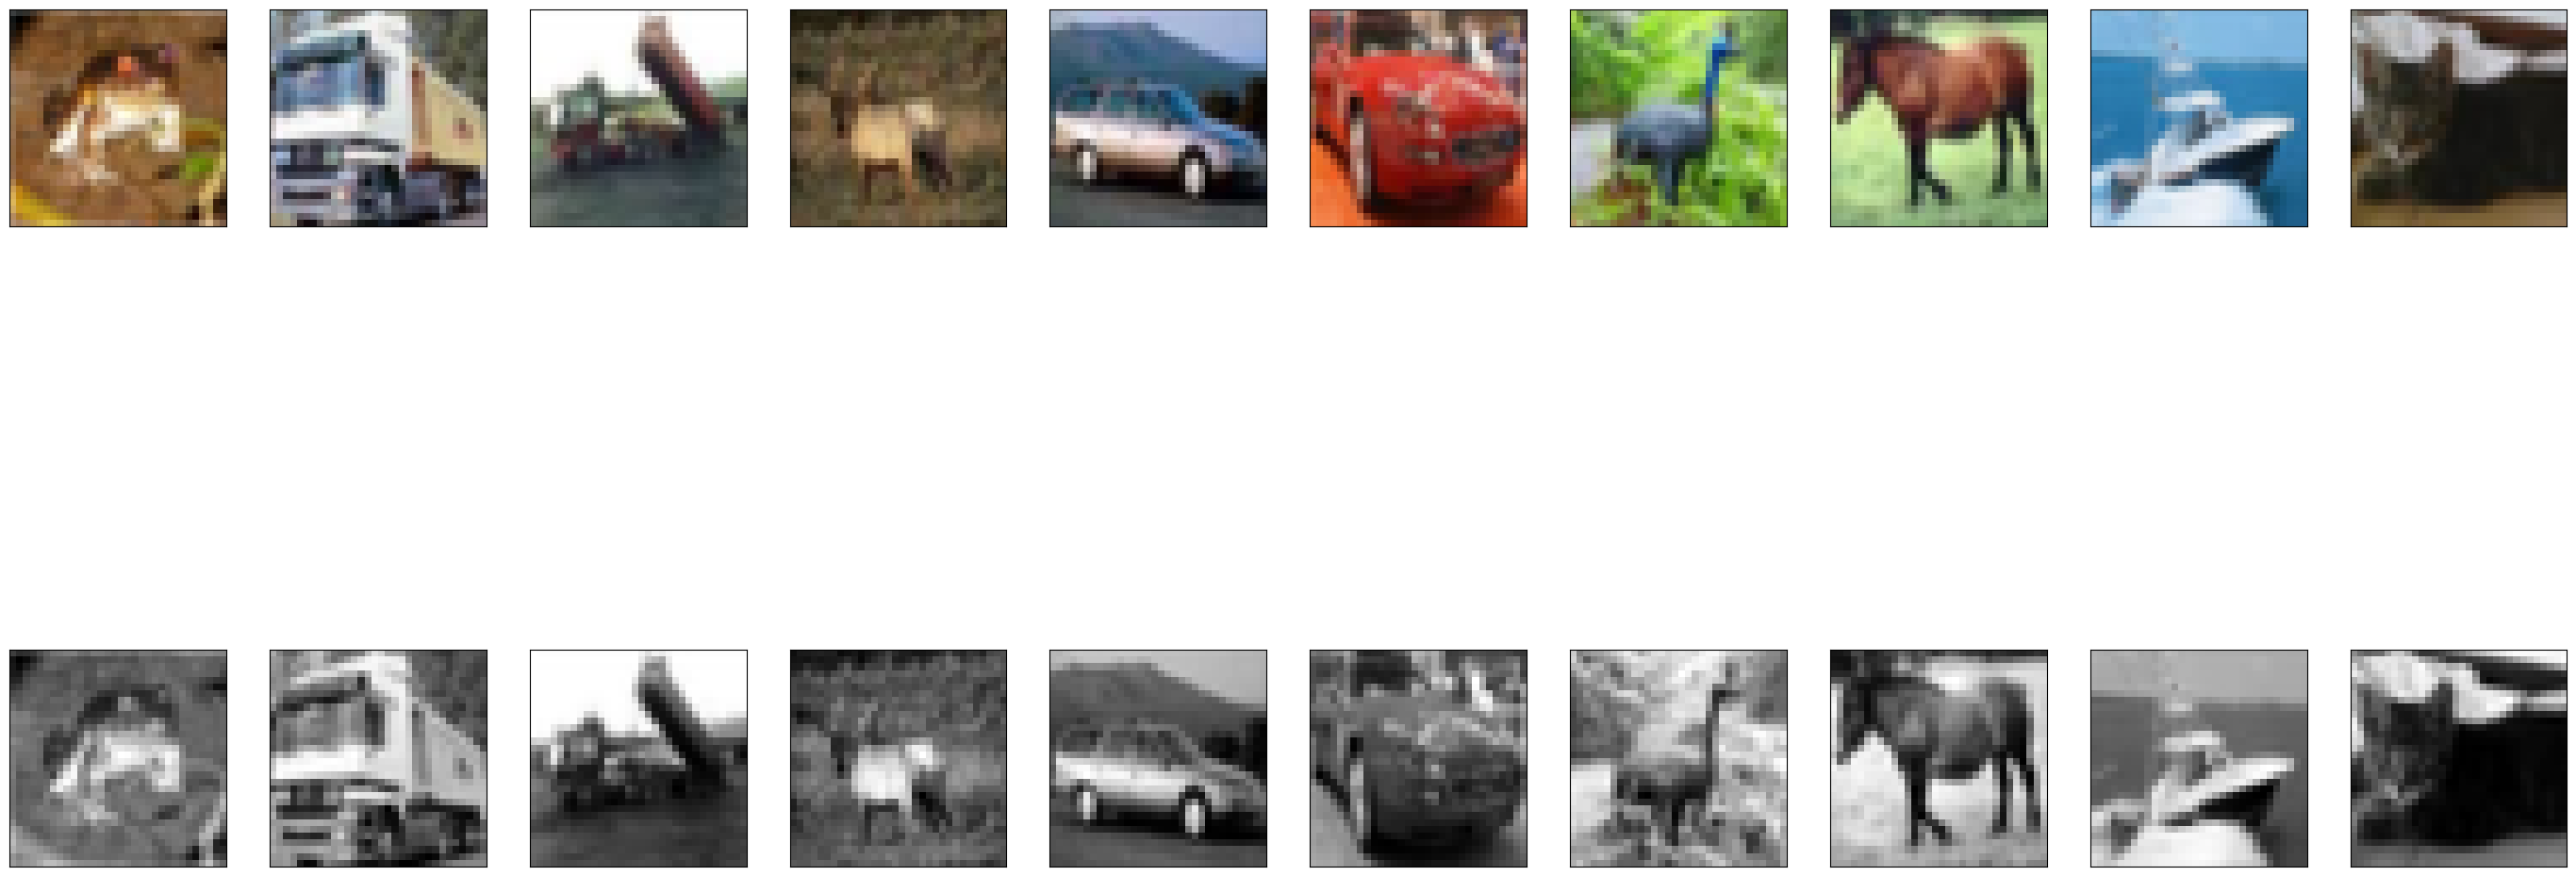

In [6]:
n=10
plt.figure(figsize=(35,25))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(X_train_gray[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

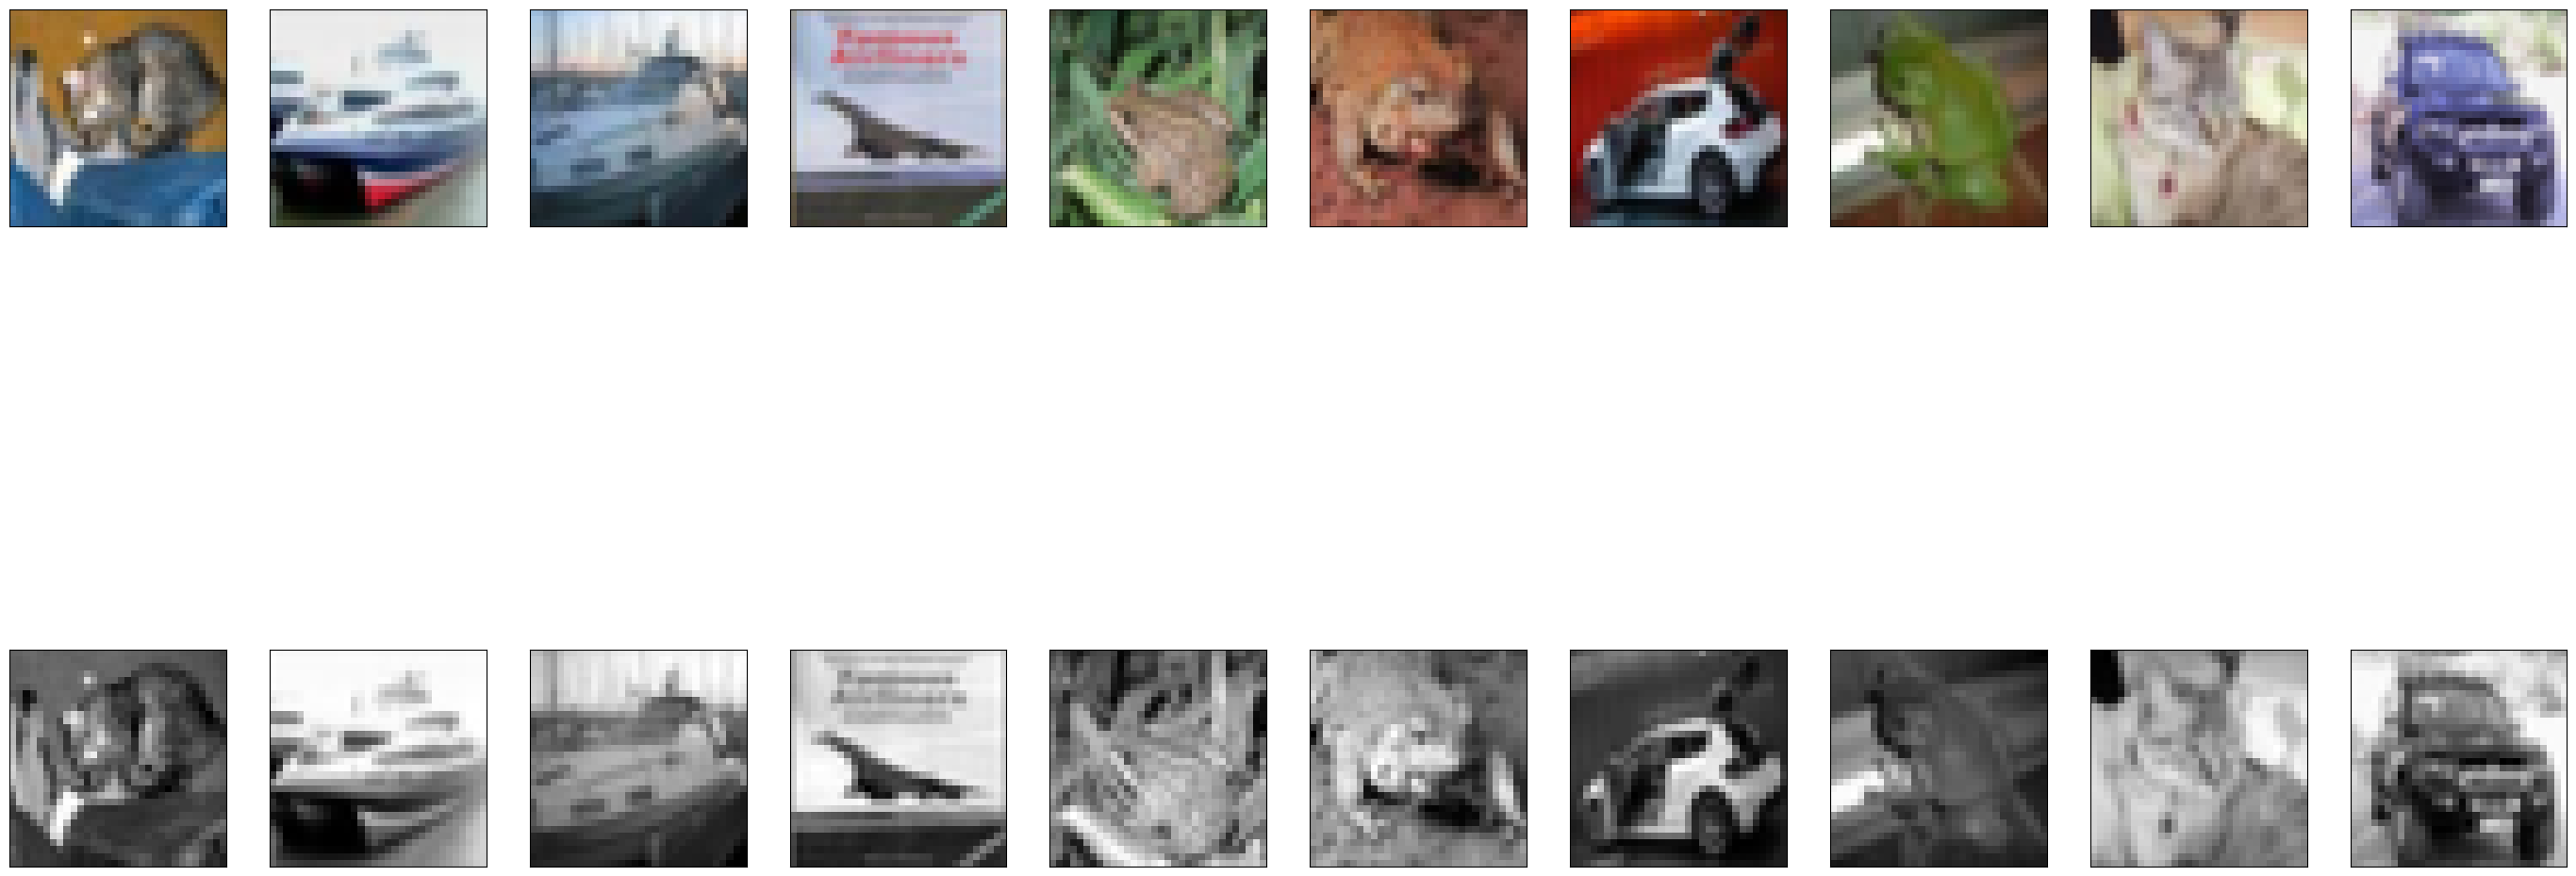

In [7]:
n=10
plt.figure(figsize=(35,25))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(X_test_gray[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [8]:
# Input layer with shape (200, 200, 1)
input_ = keras.layers.Input(shape=(32,32, 1))
# Encoder
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
encoder = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
# Decoder
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(encoder)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
# Adjust the output layer for an RGB image (3 channels)
decoder = keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)
# Autoencoder model
autoencoder = keras.models.Model(inputs=input_, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928 

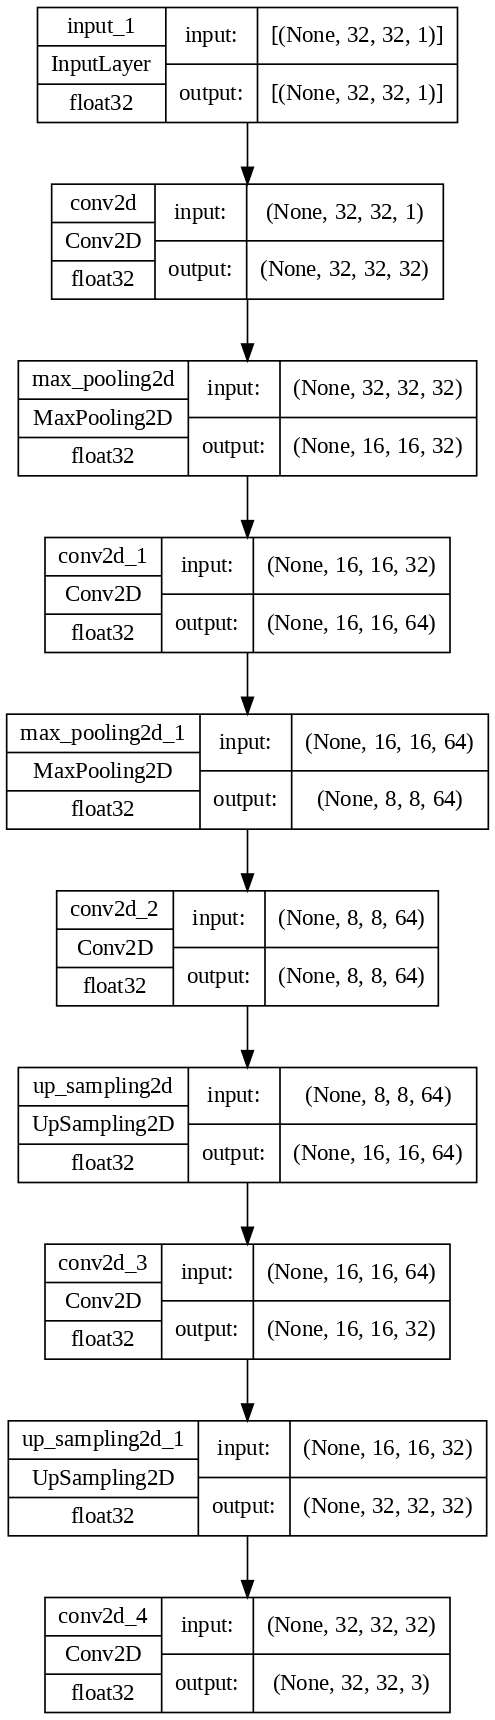

In [9]:
tf.keras.utils.plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [10]:
checkpoint_cb =ModelCheckpoint("autoencoder.h5",save_best_only=True)
autoencoder.compile(optimizer ='adam', loss='mse')
hist=autoencoder.fit(X_train_gray,X_train,epochs=200,validation_data=(X_test_gray,X_test),callbacks=[checkpoint_cb])

Epoch 1/200
1563/1563 [==============================] - 20s 8ms/step - loss: 0.0112 - val_loss: 0.0090
Epoch 2/200
  15/1563 [..............................] - ETA: 11s - loss: 0.0091

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1563 [==============================] - 10s 6ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 3/200
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 4/200
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 5/200
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 6/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 7/200
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 8/200
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 9/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 10/200
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 11/200
1563/1563 [==============================] - 8s 5ms/step - loss: 0.006

KeyboardInterrupt: 

In [11]:
autoencoder.evaluate(X_test_gray,X_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0061


0.006066922564059496

In [12]:
predictions = autoencoder.predict(X_test_gray)
predictions.shape

313/313 [==============================] - 1s 2ms/step


(10000, 32, 32, 3)

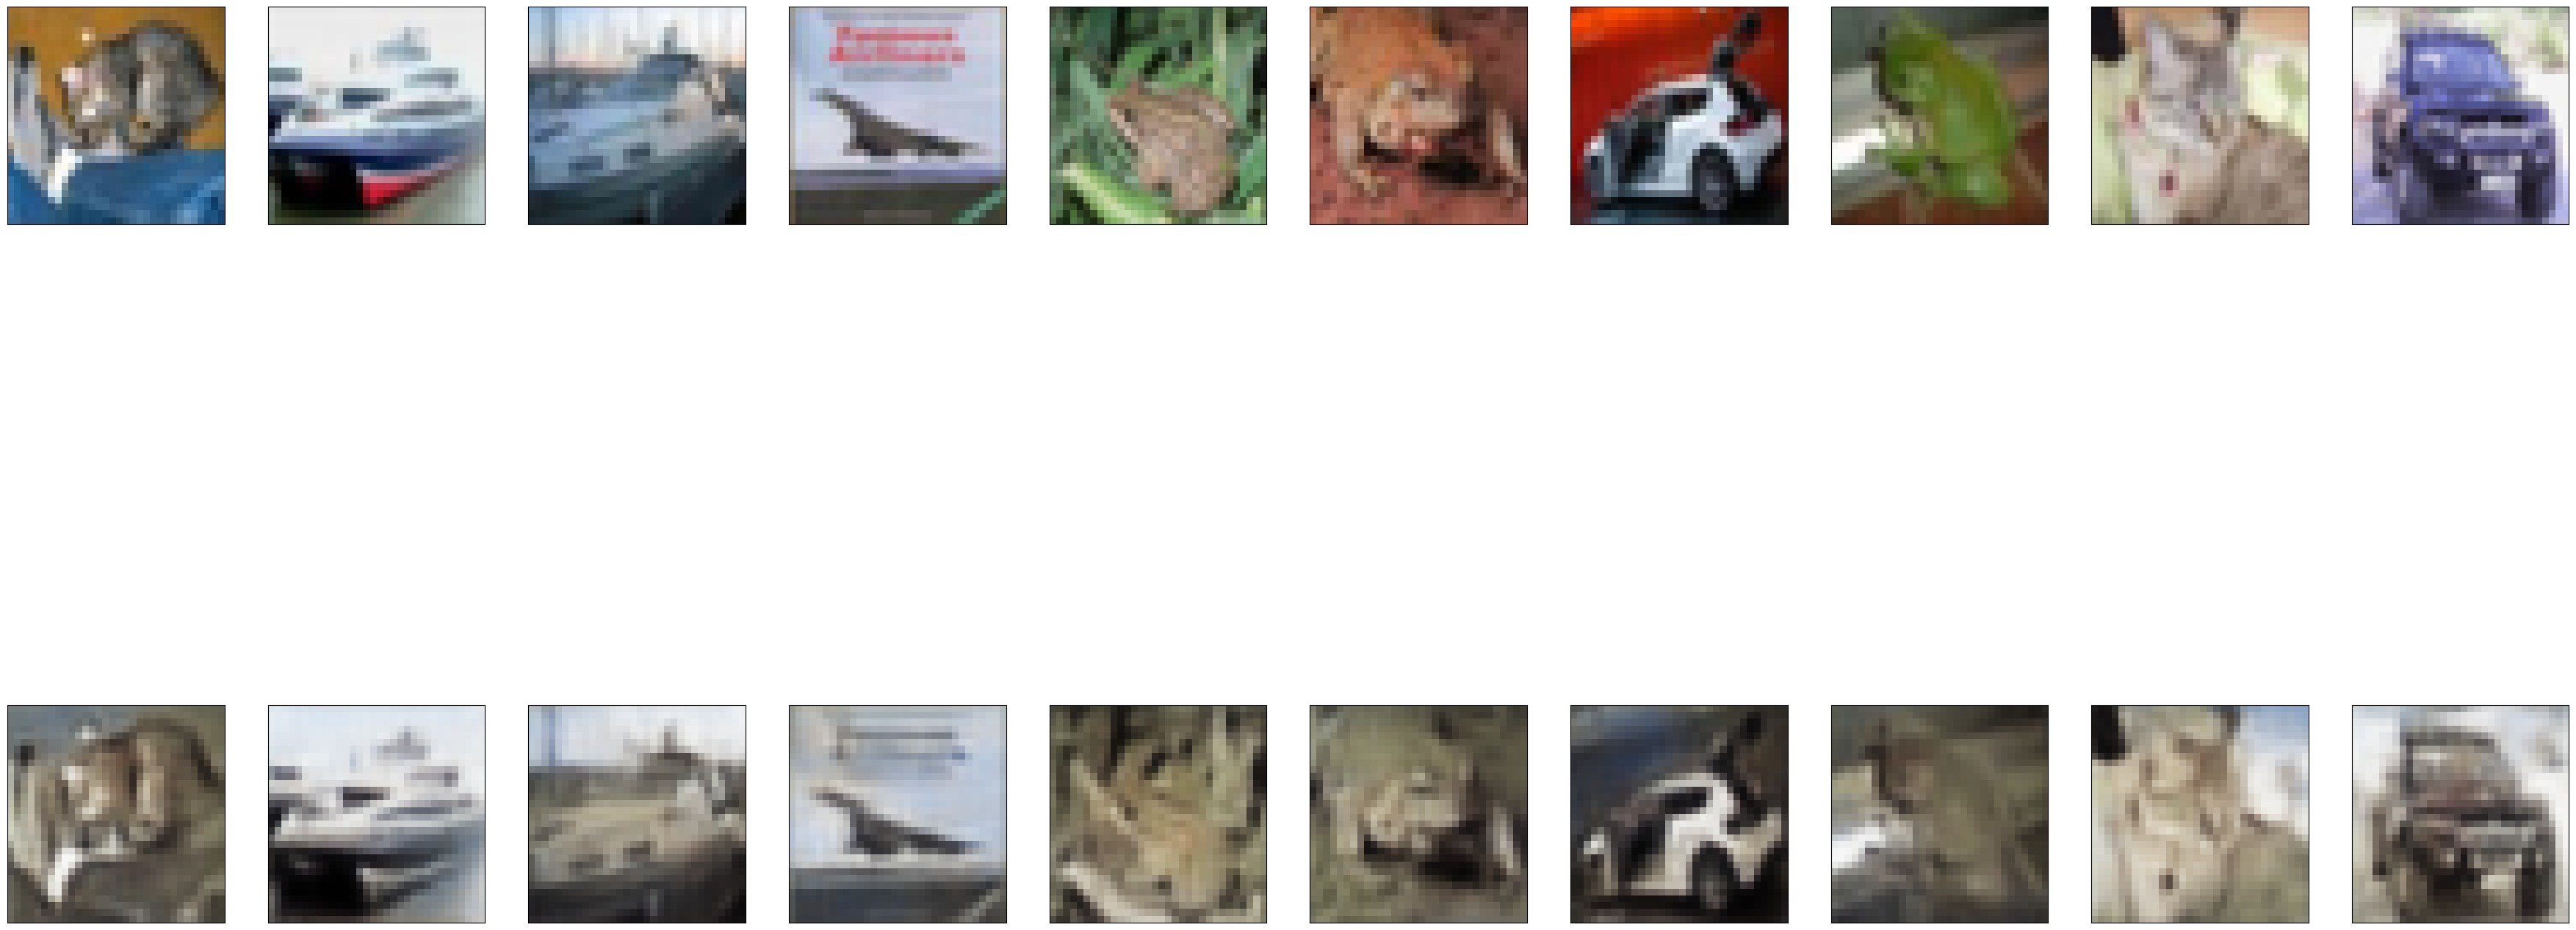

In [13]:
n=10
plt.figure(figsize=(45,35))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(predictions[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [24]:
gray_image_path = '/content/drive/MyDrive/computer vision/gray_image2.jpg'
gray_image = cv2.imread(gray_image_path, cv2.IMREAD_GRAYSCALE)
gray_image = cv2.resize(gray_image, (32, 32))  # Resize to match the input shape
gray_image = gray_image.astype('float32') / 255.0  # Normalize

# Reshape grayscale image to have a single channel dimension for the model
gray_image_rgb = gray_image.reshape((1, 32, 32, 1))  # Reshape for the model
predictions = autoencoder.predict(gray_image_rgb)

1/1 [==============================] - 0s 17ms/step


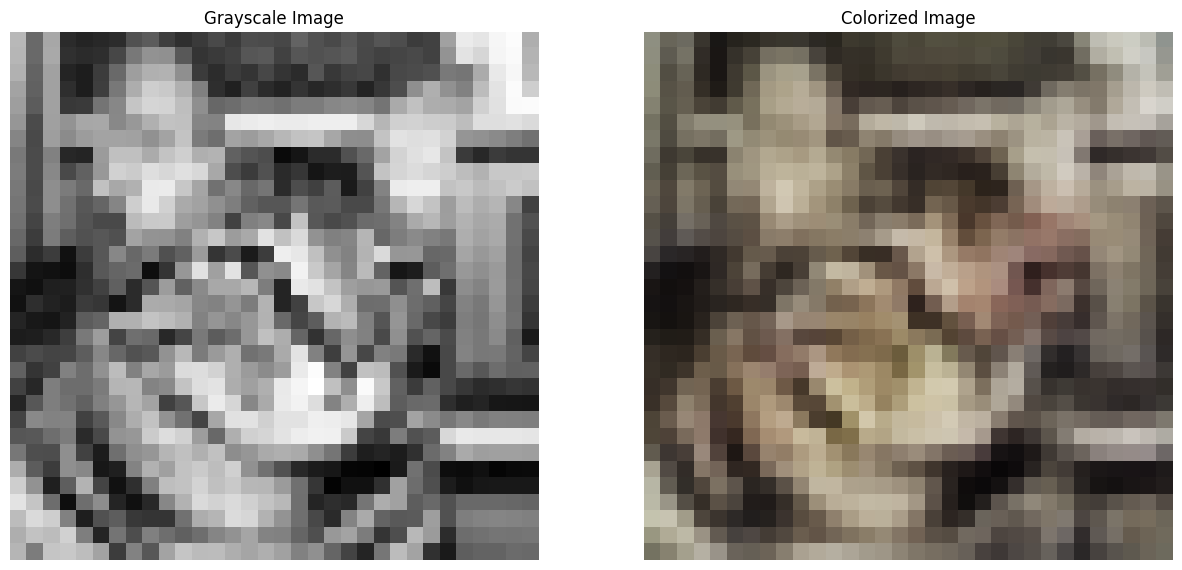

In [25]:
# Display the grayscale image and the colorized image side-by-side

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title('Grayscale Image')
axes[0].axis('off')

axes[1].imshow(predictions[0])
axes[1].set_title('Colorized Image')
axes[1].axis('off')

plt.show()